In [1]:
import pickle
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import os

from collections import deque
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, RepeatVector, LSTM, Dense, Lambda, TimeDistributed
from tensorflow.keras import losses, metrics, activations
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
import seaborn as sns

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
split = pickle.load(open('./final_data_ST_120_2019.pkl', 'rb'))['ST4000DM000']
file_list = os.listdir('./ST4000DM000')
train_list = split['train']
val_list = split['val']
test_list = split['test']
col = ['smart_7_raw', 'smart_9_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw', 'until_fail_days']
timestep_list = [5, 10, 20, 30]

In [3]:
scaler_path = './std_scaler.pkl'
scaler_zip = {f'{file_name[:-4]}':{} for file_name in file_list}
if not os.path.isfile(scaler_path):
    for file_name in file_list:
        db = pickle.load(open(f'./ST4000DM000/{file_name}', 'rb'))
        for db_type in [30, 60, 120]:
            temp = db[db['until_fail_days']>db_type][col[:-1]]
            if len(temp) != 0:
                scaler = StandardScaler()
                scaler.fit(temp)
                scaler_zip[f'{file_name[:-4]}'][f'{db_type}'] = scaler
    
    pickle.dump(scaler_zip, open(scaler_path, 'wb'))
else:
    scaler_zip = pickle.load(open(scaler_path, 'rb'))

In [4]:
db_path = './STD_DB/db_120.pkl'
if not os.path.isfile(db_path):
    db_zip_120 = {f'{t}': {'train':[], 'val':[], 'test':[]} for t in timestep_list}
    for file_name in file_list:
        db = pickle.load(open(f'./ST4000DM000/{file_name}', 'rb'))
        db = db[db['until_fail_days']>120][col[:-1]]
        for t in timestep_list:
            if len(db) >= t:
                scaled_db = scaler_zip[f'{file_name[:-4]}']['120'].transform(db)
                if file_name[:-4] in train_list:
                    db_zip_120[f'{t}']['train'].append([scaled_db[line:line+t] for line in range(0, len(scaled_db)-t+1)])
                elif file_name[:-4] in val_list:
                    db_zip_120[f'{t}']['val'].append([scaled_db[line:line+t] for line in range(0, len(scaled_db)-t+1)])
                elif file_name[:-4] in test_list:
                    db_zip_120[f'{t}']['test'].append([scaled_db[line:line+t] for line in range(0, len(scaled_db)-t+1)])
                    
    for t in timestep_list:
        db_zip_120[f'{t}']['train'] = np.concatenate(db_zip_120[f'{t}']['train'])
        db_zip_120[f'{t}']['val'] = np.concatenate(db_zip_120[f'{t}']['val'])
        db_zip_120[f'{t}']['test'] = np.concatenate(db_zip_120[f'{t}']['test'])
    pickle.dump(db_zip_120, open(db_path, 'wb'))
else:
    db_zip_120 = pickle.load(open(db_path, 'rb'))

In [5]:
db_path = './STD_DB/db_60.pkl'
if not os.path.isfile(db_path):
    db_zip_60 = {f'{t}': {'train':[], 'val':[], 'test':[]} for t in timestep_list}
    for file_name in file_list:
        db = pickle.load(open(f'./ST4000DM000/{file_name}', 'rb'))
        db = db[db['until_fail_days']>60][col[:-1]]
        for t in timestep_list:
            if len(db) >= t:
                scaled_db = scaler_zip[f'{file_name[:-4]}']['60'].transform(db)
                if file_name[:-4] in train_list:
                    db_zip_60[f'{t}']['train'].append([scaled_db[line:line+t] for line in range(0, len(scaled_db)-t+1)])
                elif file_name[:-4] in val_list:
                    db_zip_60[f'{t}']['val'].append([scaled_db[line:line+t] for line in range(0, len(scaled_db)-t+1)])
                elif file_name[:-4] in test_list:
                    db_zip_60[f'{t}']['test'].append([scaled_db[line:line+t] for line in range(0, len(scaled_db)-t+1)])
                    
    for t in timestep_list:
        db_zip_60[f'{t}']['train'] = np.concatenate(db_zip_60[f'{t}']['train'])
        db_zip_60[f'{t}']['val'] = np.concatenate(db_zip_60[f'{t}']['val'])
        db_zip_60[f'{t}']['test'] = np.concatenate(db_zip_60[f'{t}']['test'])
    pickle.dump(db_zip_60, open(db_path, 'wb'))
else:
    db_zip_60 = pickle.load(open(db_path, 'rb'))

In [6]:
db_path = './STD_DB/db_30.pkl'
if not os.path.isfile(db_path):
    db_zip_30 = {f'{t}': {'train':[], 'val':[], 'test':[]} for t in timestep_list}
    for file_name in file_list:
        db = pickle.load(open(f'./ST4000DM000/{file_name}', 'rb'))
        db = db[db['until_fail_days']>30][col[:-1]]
        for t in timestep_list:
            if len(db) >= t:
                scaled_db = scaler_zip[f'{file_name[:-4]}']['30'].transform(db)
                if file_name[:-4] in train_list:
                    db_zip_30[f'{t}']['train'].append([scaled_db[line:line+t] for line in range(0, len(scaled_db)-t+1)])
                elif file_name[:-4] in val_list:
                    db_zip_30[f'{t}']['val'].append([scaled_db[line:line+t] for line in range(0, len(scaled_db)-t+1)])
                elif file_name[:-4] in test_list:
                    db_zip_30[f'{t}']['test'].append([scaled_db[line:line+t] for line in range(0, len(scaled_db)-t+1)])
                    
    for t in timestep_list:
        db_zip_30[f'{t}']['train'] = np.concatenate(db_zip_30[f'{t}']['train'])
        db_zip_30[f'{t}']['val'] = np.concatenate(db_zip_30[f'{t}']['val'])
        db_zip_30[f'{t}']['test'] = np.concatenate(db_zip_30[f'{t}']['test'])
    pickle.dump(db_zip_30, open(db_path, 'wb'))
else:
    db_zip_30 = pickle.load(open(db_path, 'rb'))

In [7]:
db_path = './G_DB/db_60.pkl'
if not os.path.isfile(db_path):
    dbg_zip_60 = {f'{t}': [] for t in timestep_list}
    for t in timestep_list:
        dbg_zip_60[f'{t}'] = pickle.load(open(f'./G_DB/generated_db_days60_seq{t}.pkl', 'rb'))
        dbg_zip_60[f'{t}'] = np.concatenate([dbg_zip_60[f'{t}'], db_zip_60[f'{t}']['train']])
        
    pickle.dump(dbg_zip_60, open(db_path, 'wb'))
else:
    dbg_zip_60 = pickle.load(open(db_path, 'rb'))

In [8]:
db_path = './G_DB/db_120.pkl'
if not os.path.isfile(db_path):
    dbg_zip_120 = {f'{t}': [] for t in timestep_list}
    for t in timestep_list:
        dbg_zip_120[f'{t}'] = pickle.load(open(f'./G_DB/generated_db_days120_seq{t}.pkl', 'rb'))
        dbg_zip_120[f'{t}'] = np.concatenate([dbg_zip_120[f'{t}'], db_zip_120[f'{t}']['train']])
        
    pickle.dump(dbg_zip_120, open(db_path, 'wb'))
else:
    dbg_zip_120 = pickle.load(open(db_path, 'rb'))

In [9]:
db_path = './G_DB/db_30.pkl'
if not os.path.isfile(db_path):
    dbg_zip_30 = {f'{t}': [] for t in timestep_list}
    for t in timestep_list:
        dbg_zip_30[f'{t}'] = pickle.load(open(f'./G_DB/generated_db_days30_seq{t}.pkl', 'rb'))
        dbg_zip_30[f'{t}'] = np.concatenate([dbg_zip_30[f'{t}'], db_zip_30[f'{t}']['train']])
        
    pickle.dump(dbg_zip_30, open(db_path, 'wb'))
else:
    dbg_zip_30 = pickle.load(open(db_path, 'rb'))

In [10]:
def flatten(X):
    '''
    Flatten a 3D array.

    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.

    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1] - 1), :]
    return (flattened_X)

In [11]:
def lstm_ae(db, n_dimensions):
    time_step, input_dim = db.shape[1], db.shape[2]
    inputs = Input(shape=(time_step, input_dim))
    encoded = LSTM(n_dimensions, return_sequences=True, name="encoder_01")(inputs)
    encoded = LSTM(int(n_dimensions/2), return_sequences=False, name="encoder_02")(encoded)
    decoded = RepeatVector(time_step)(encoded)
    decoded = LSTM(int(input_dim/2), return_sequences=True, name='decoder_01')(decoded)
    decoded = LSTM(n_dimensions, return_sequences=True, name='decoder_02')(decoded)
    output = TimeDistributed(Dense(input_dim))(decoded)


    autoencoder = Model(inputs, output)
    autoencoder.compile(optimizer='adam', loss='mse', metrics=['cosine_proximity'])
    autoencoder.summary()
    return autoencoder

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 5)]            0         
                                                                 
 encoder_01 (LSTM)           (None, 5, 32)             4864      
                                                                 
 encoder_02 (LSTM)           (None, 16)                3136      
                                                                 
 repeat_vector (RepeatVector  (None, 5, 16)            0         
 )                                                               
                                                                 
 decoder_01 (LSTM)           (None, 5, 2)              152       
                                                                 
 decoder_02 (LSTM)           (None, 5, 32)             4480      
                                                             

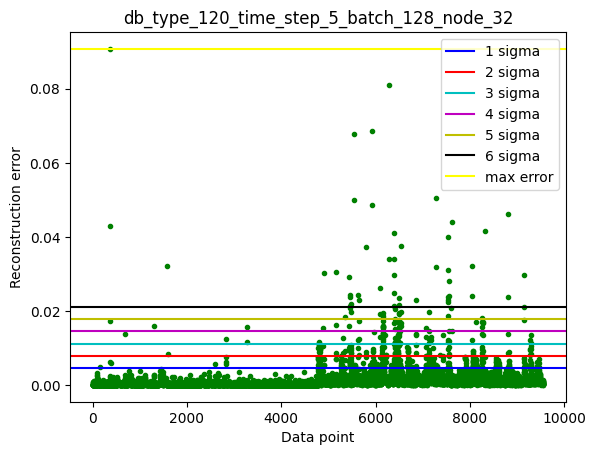

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 5)]            0         
                                                                 
 encoder_01 (LSTM)           (None, 5, 64)             17920     
                                                                 
 encoder_02 (LSTM)           (None, 32)                12416     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 5, 32)            0         
 or)                                                             
                                                                 
 decoder_01 (LSTM)           (None, 5, 2)              280       
                                                                 
 decoder_02 (LSTM)           (None, 5, 64)             17152     
                                                           

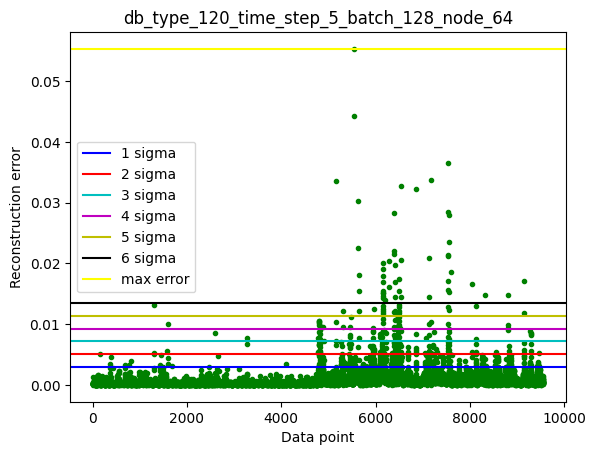

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5, 5)]            0         
                                                                 
 encoder_01 (LSTM)           (None, 5, 128)            68608     
                                                                 
 encoder_02 (LSTM)           (None, 64)                49408     
                                                                 
 repeat_vector_2 (RepeatVect  (None, 5, 64)            0         
 or)                                                             
                                                                 
 decoder_01 (LSTM)           (None, 5, 2)              536       
                                                                 
 decoder_02 (LSTM)           (None, 5, 128)            67072     
                                                           

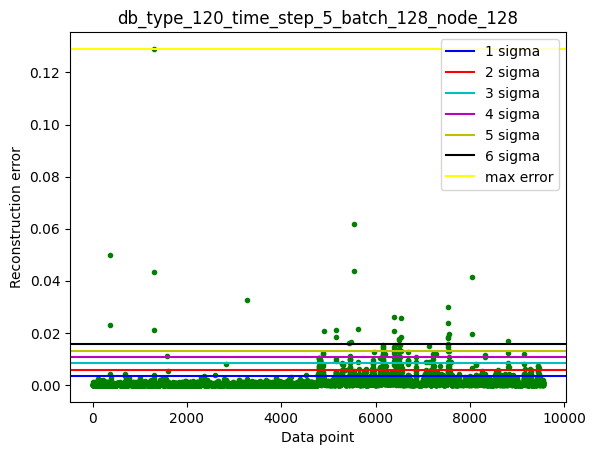

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 5)]            0         
                                                                 
 encoder_01 (LSTM)           (None, 5, 256)            268288    
                                                                 
 encoder_02 (LSTM)           (None, 128)               197120    
                                                                 
 repeat_vector_3 (RepeatVect  (None, 5, 128)           0         
 or)                                                             
                                                                 
 decoder_01 (LSTM)           (None, 5, 2)              1048      
                                                                 
 decoder_02 (LSTM)           (None, 5, 256)            265216    
                                                           

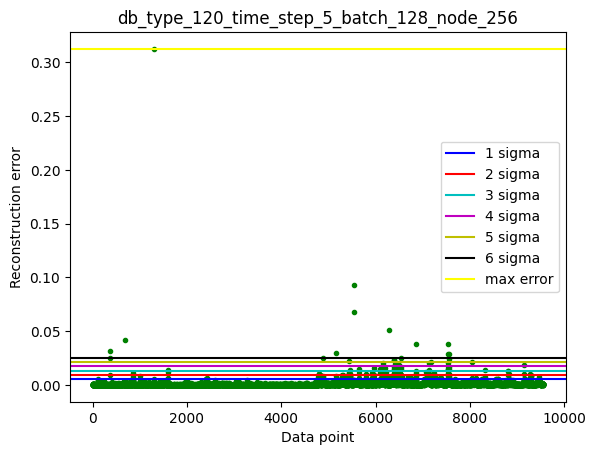

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 10, 5)]           0         
                                                                 
 encoder_01 (LSTM)           (None, 10, 32)            4864      
                                                                 
 encoder_02 (LSTM)           (None, 16)                3136      
                                                                 
 repeat_vector_4 (RepeatVect  (None, 10, 16)           0         
 or)                                                             
                                                                 
 decoder_01 (LSTM)           (None, 10, 2)             152       
                                                                 
 decoder_02 (LSTM)           (None, 10, 32)            4480      
                                                           

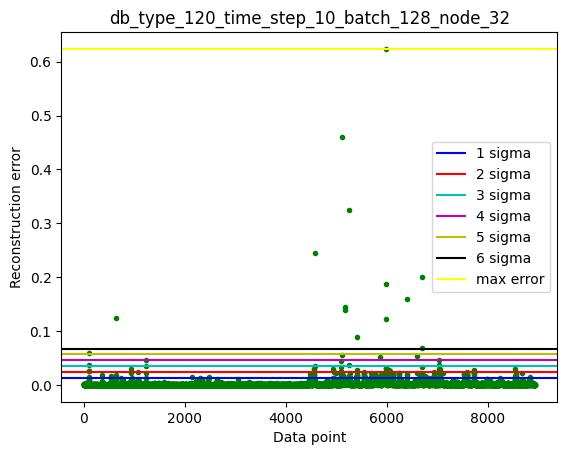

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 10, 5)]           0         
                                                                 
 encoder_01 (LSTM)           (None, 10, 64)            17920     
                                                                 
 encoder_02 (LSTM)           (None, 32)                12416     
                                                                 
 repeat_vector_5 (RepeatVect  (None, 10, 32)           0         
 or)                                                             
                                                                 
 decoder_01 (LSTM)           (None, 10, 2)             280       
                                                                 
 decoder_02 (LSTM)           (None, 10, 64)            17152     
                                                           

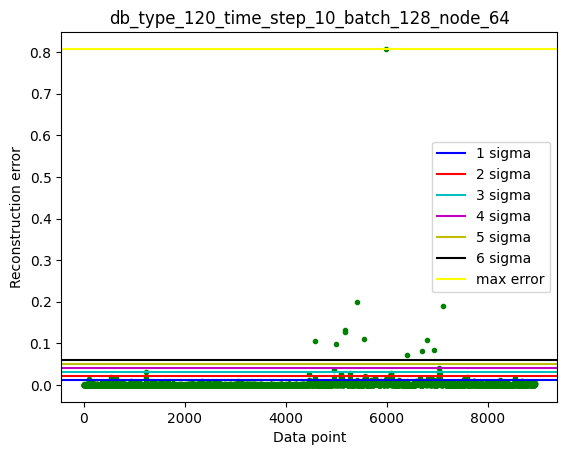

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 10, 5)]           0         
                                                                 
 encoder_01 (LSTM)           (None, 10, 128)           68608     
                                                                 
 encoder_02 (LSTM)           (None, 64)                49408     
                                                                 
 repeat_vector_6 (RepeatVect  (None, 10, 64)           0         
 or)                                                             
                                                                 
 decoder_01 (LSTM)           (None, 10, 2)             536       
                                                                 
 decoder_02 (LSTM)           (None, 10, 128)           67072     
                                                           

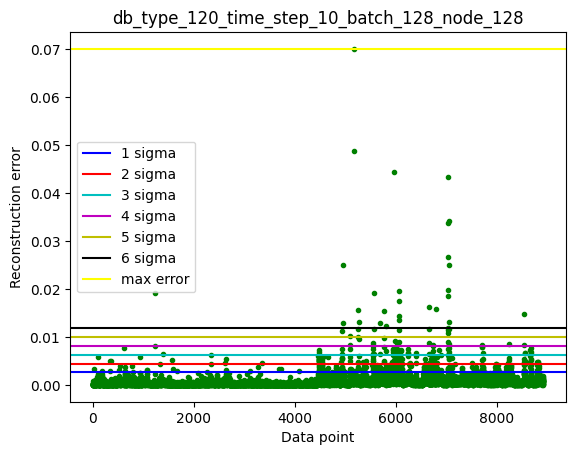

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 10, 5)]           0         
                                                                 
 encoder_01 (LSTM)           (None, 10, 256)           268288    
                                                                 
 encoder_02 (LSTM)           (None, 128)               197120    
                                                                 
 repeat_vector_7 (RepeatVect  (None, 10, 128)          0         
 or)                                                             
                                                                 
 decoder_01 (LSTM)           (None, 10, 2)             1048      
                                                                 
 decoder_02 (LSTM)           (None, 10, 256)           265216    
                                                           

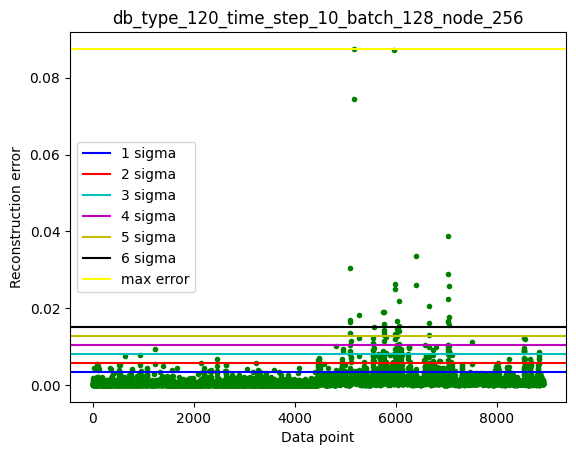

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 20, 5)]           0         
                                                                 
 encoder_01 (LSTM)           (None, 20, 32)            4864      
                                                                 
 encoder_02 (LSTM)           (None, 16)                3136      
                                                                 
 repeat_vector_8 (RepeatVect  (None, 20, 16)           0         
 or)                                                             
                                                                 
 decoder_01 (LSTM)           (None, 20, 2)             152       
                                                                 
 decoder_02 (LSTM)           (None, 20, 32)            4480      
                                                           

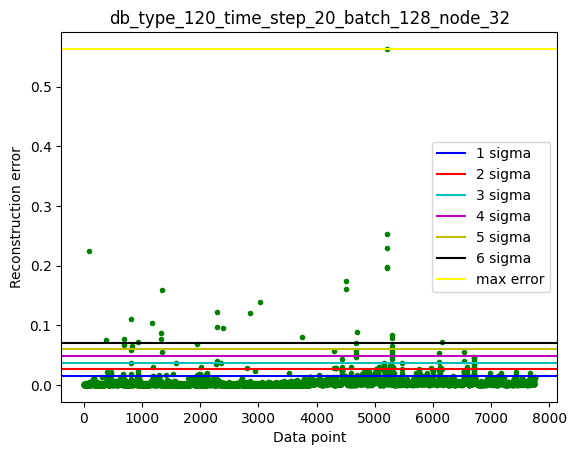

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 20, 5)]           0         
                                                                 
 encoder_01 (LSTM)           (None, 20, 64)            17920     
                                                                 
 encoder_02 (LSTM)           (None, 32)                12416     
                                                                 
 repeat_vector_9 (RepeatVect  (None, 20, 32)           0         
 or)                                                             
                                                                 
 decoder_01 (LSTM)           (None, 20, 2)             280       
                                                                 
 decoder_02 (LSTM)           (None, 20, 64)            17152     
                                                           

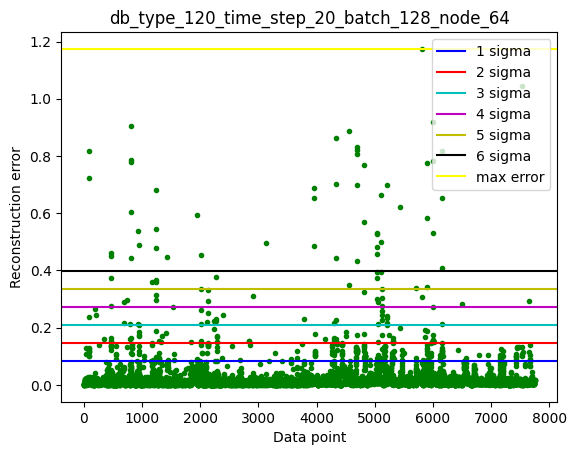

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 20, 5)]           0         
                                                                 
 encoder_01 (LSTM)           (None, 20, 128)           68608     
                                                                 
 encoder_02 (LSTM)           (None, 64)                49408     
                                                                 
 repeat_vector_10 (RepeatVec  (None, 20, 64)           0         
 tor)                                                            
                                                                 
 decoder_01 (LSTM)           (None, 20, 2)             536       
                                                                 
 decoder_02 (LSTM)           (None, 20, 128)           67072     
                                                          

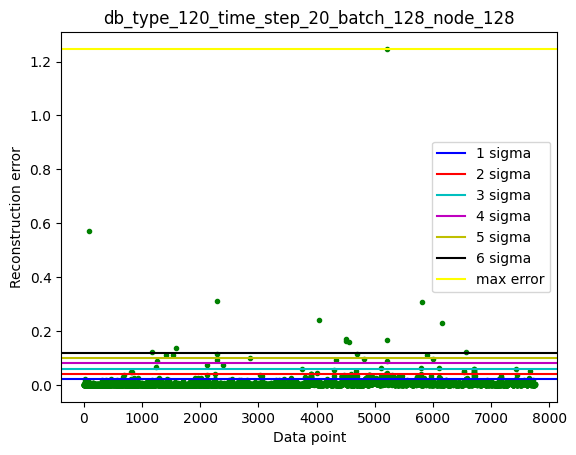

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 20, 5)]           0         
                                                                 
 encoder_01 (LSTM)           (None, 20, 256)           268288    
                                                                 
 encoder_02 (LSTM)           (None, 128)               197120    
                                                                 
 repeat_vector_11 (RepeatVec  (None, 20, 128)          0         
 tor)                                                            
                                                                 
 decoder_01 (LSTM)           (None, 20, 2)             1048      
                                                                 
 decoder_02 (LSTM)           (None, 20, 256)           265216    
                                                          

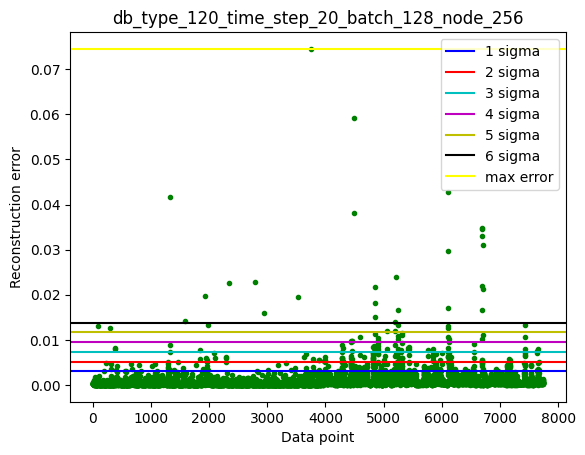

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 30, 5)]           0         
                                                                 
 encoder_01 (LSTM)           (None, 30, 32)            4864      
                                                                 
 encoder_02 (LSTM)           (None, 16)                3136      
                                                                 
 repeat_vector_12 (RepeatVec  (None, 30, 16)           0         
 tor)                                                            
                                                                 
 decoder_01 (LSTM)           (None, 30, 2)             152       
                                                                 
 decoder_02 (LSTM)           (None, 30, 32)            4480      
                                                          

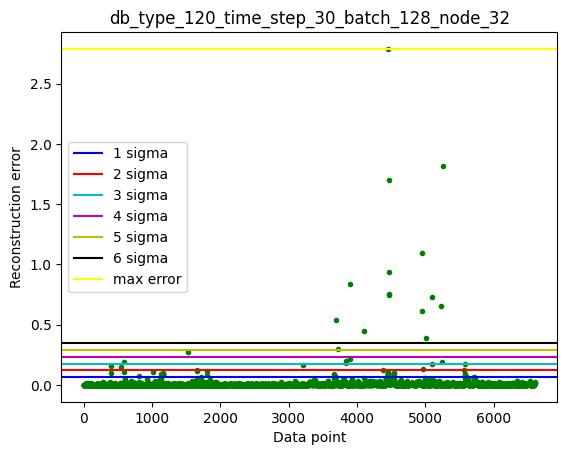

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 30, 5)]           0         
                                                                 
 encoder_01 (LSTM)           (None, 30, 64)            17920     
                                                                 
 encoder_02 (LSTM)           (None, 32)                12416     
                                                                 
 repeat_vector_13 (RepeatVec  (None, 30, 32)           0         
 tor)                                                            
                                                                 
 decoder_01 (LSTM)           (None, 30, 2)             280       
                                                                 
 decoder_02 (LSTM)           (None, 30, 64)            17152     
                                                          

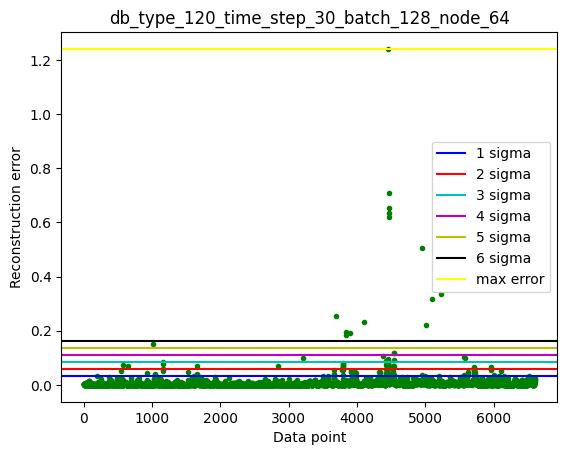

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 30, 5)]           0         
                                                                 
 encoder_01 (LSTM)           (None, 30, 128)           68608     
                                                                 
 encoder_02 (LSTM)           (None, 64)                49408     
                                                                 
 repeat_vector_14 (RepeatVec  (None, 30, 64)           0         
 tor)                                                            
                                                                 
 decoder_01 (LSTM)           (None, 30, 2)             536       
                                                                 
 decoder_02 (LSTM)           (None, 30, 128)           67072     
                                                          

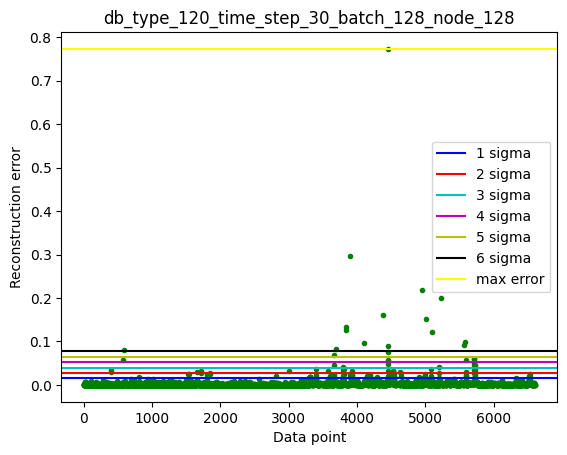

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 30, 5)]           0         
                                                                 
 encoder_01 (LSTM)           (None, 30, 256)           268288    
                                                                 
 encoder_02 (LSTM)           (None, 128)               197120    
                                                                 
 repeat_vector_15 (RepeatVec  (None, 30, 128)          0         
 tor)                                                            
                                                                 
 decoder_01 (LSTM)           (None, 30, 2)             1048      
                                                                 
 decoder_02 (LSTM)           (None, 30, 256)           265216    
                                                          

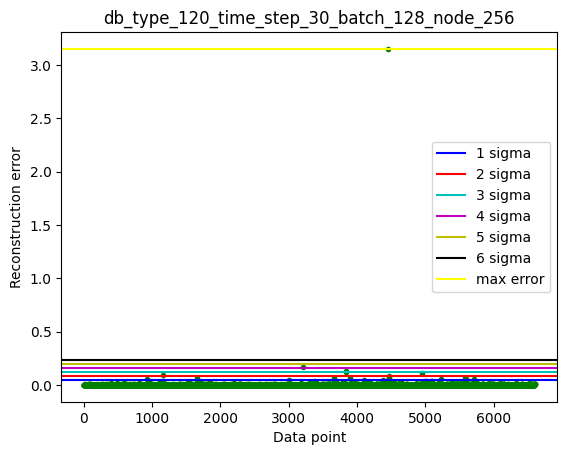

In [13]:
# db_type = [30, 60, 120]
db_type = [120]
epoch = 500
batch_size = 128
n_dimensions = [32, 64, 128, 256]

for temp in db_type:
    if temp == 60:
        db = db_zip_60
        dbg = dbg_zip_60
    elif temp == 120:
        db = db_zip_120
        dbg = dbg_zip_120
    elif temp == 30:
        db = db_zip_30
        dbg = dbg_zip_30
        
    for time_step in timestep_list:
        for node in n_dimensions:
            save_file_name = f'db_type_{temp}_time_step_{time_step}_batch_{batch_size}_node_{node}_gen.h5'
            db_path = f"./Model_G_STD/{save_file_name[:-3]}"
            if not os.path.exists(db_path):
                os.mkdir(db_path)

            callback = EarlyStopping(monitor='val_loss', patience=30, mode='min')
            mc = ModelCheckpoint(f'{db_path}/{save_file_name}', monitor='val_loss', mode='min', save_best_only=True)
        
            model = lstm_ae(db=dbg[f'{time_step}'], n_dimensions=node)
            history = model.fit(x=dbg[f'{time_step}'], y=dbg[f'{time_step}'], validation_data=(db[f'{time_step}']['val'], db[f'{time_step}']['val']), epochs=epoch, batch_size=batch_size, callbacks=[callback, mc])
            pickle.dump(history.history, open(f'{db_path}/history.pkl', 'wb'))
            
            
            threshold = {}
            train_pred = model.predict(dbg[f'{time_step}'])
            mse = np.mean(np.power(flatten(dbg[f'{time_step}']) - flatten(train_pred), 2), axis=1)
            error = pd.DataFrame({'reconstruction_error': mse, })
            temp_ = error.describe()
            for sigma in range(1,7,1):
                threshold[sigma] = (temp_.iloc[1].values) + (sigma * (temp_.iloc[2].values))
            threshold['max'] = max(mse)

            plt.plot(mse, 'g.')
            plt.axhline(threshold[1], color='b', label='1 sigma')
            plt.axhline(threshold[2], color='r', label='2 sigma')
            plt.axhline(threshold[3], color='c', label='3 sigma')
            plt.axhline(threshold[4], color='m', label='4 sigma')
            plt.axhline(threshold[5], color='y', label='5 sigma')
            plt.axhline(threshold[6], color='k', label='6 sigma')
            plt.axhline(threshold['max'], color='yellow', label='max error')

            plt.xlabel('Data point')
            plt.ylabel('Reconstruction error')
            plt.title(f'db_type_{temp}_time_step_{time_step}_batch_{batch_size}_node_{node}')
            plt.legend()
            plt.savefig(f'{db_path}/db_type_{temp}_time_step_{time_step}_batch_{batch_size}_node_{node}.png')
            pickle.dump(threshold, open(f'{db_path}/threshold.pkl', 'wb'))
            plt.show()

In [16]:
test_db_120 = {f'{t}': {'x':[], 'y':[]} for t in timestep_list}
for test_file_name in test_list:
    db = pickle.load(open(f'./ST4000DM000/{test_file_name}.pkl', 'rb'))
    scaled_db = scaler_zip[f'{test_file_name}']['120'].transform(db[col[:-1]])
    for t in timestep_list:
        for line in range(0, len(scaled_db)-t+1):
            test_db_120[f'{t}']['x'].append(scaled_db[line:line+t])
            if db.iloc[line+t-1]['until_fail_days'] > 120:
                test_db_120[f'{t}']['y'].append(0)
            else:
                test_db_120[f'{t}']['y'].append(1)

test_db_60 = {f'{t}': {'x':[], 'y':[]} for t in timestep_list}
for test_file_name in test_list:
    db = pickle.load(open(f'./ST4000DM000/{test_file_name}.pkl', 'rb'))
    scaled_db = scaler_zip[f'{test_file_name}']['60'].transform(db[col[:-1]])
    for t in timestep_list:
        for line in range(0, len(scaled_db)-t+1):
            test_db_60[f'{t}']['x'].append(scaled_db[line:line+t])
            if db.iloc[line+t-1]['until_fail_days'] > 60:
                test_db_60[f'{t}']['y'].append(0)
            else:
                test_db_60[f'{t}']['y'].append(1)
                
test_db_30 = {f'{t}': {'x':[], 'y':[]} for t in timestep_list}
for test_file_name in test_list:
    db = pickle.load(open(f'./ST4000DM000/{test_file_name}.pkl', 'rb'))
    scaled_db = scaler_zip[f'{test_file_name}']['30'].transform(db[col[:-1]])
    for t in timestep_list:
        for line in range(0, len(scaled_db)-t+1):
            test_db_30[f'{t}']['x'].append(scaled_db[line:line+t])
            if db.iloc[line+t-1]['until_fail_days'] > 30:
                test_db_30[f'{t}']['y'].append(0)
            else:
                test_db_30[f'{t}']['y'].append(1)

In [18]:
model_folder = os.listdir('./Model_G_STD')
result = {f'{num}':{} for num in range(len(model_folder))}
for num, folder in enumerate(model_folder):
    for i in os.listdir(f'./Model_G_STD/{folder}'):
        if i[-2:] == 'h5':
            model = tf.keras.models.load_model(f'./Model_G_STD/{folder}/{i}')
            if folder.split('_')[2] == '60':
                db = test_db_60
            elif folder.split('_')[2] == '120':
                db = test_db_120
            elif folder.split('_')[2] == '30':
                db = test_db_30
            t = int(folder.split('_')[5])
            
            print(f'db_type: {folder.split("_")[2]}, time_step: {t}, node: {folder.split("_")[-2]}')
            print(f'Max_RE: {pickle.load(open(f"./Model_G_STD/{folder}/threshold.pkl", "rb"))["max"]}')
            
            test_pred = model.predict(np.array(db[f'{t}']['x']))
            mse = np.mean(np.power(flatten(np.array(db[f'{t}']['x'])) - flatten(test_pred), 2), axis=1)
            error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': db[f'{t}']['y']})
            
            normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
            fraud_error_df = error_df[error_df['true_class'] == 1]
            
            fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
            roc_auc = auc(fpr, tpr)
            precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
            
            J = tpr - fpr
            ix = np.argmax(J)
            best_thresh = thresholds[ix]
            print(f"AUC: {roc_auc}")
            print(f"best_threshold: {best_thresh}")
            
            result[f'{num}']['db_type'] = folder.split("_")[2]
            result[f'{num}']['time_step'] = t
            result[f'{num}']['node'] = folder.split("_")[-2]
            result[f'{num}']['AUC'] = roc_auc
            result[f'{num}']['Max_RE'] = pickle.load(open(f"./Model_G_STD/{folder}/threshold.pkl", "rb"))["max"]
            result[f'{num}']['best_threshold'] = best_thresh

            # groups = error_df.groupby('true_class')
            # fig, ax = plt.subplots()

            # for name, group in groups:
            #     ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            #             label= "Failure" if name == 1 else "Normal")
            # ax.hlines(best_thresh, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
            # ax.legend()
            # plt.title("Reconstruction error for different classes")
            # plt.ylabel("Reconstruction error")
            # plt.xlabel("Data point index")
            # plt.show();
            
            # LABELS = ["Normal", "Failure"]
            # y_pred = [1 if e > best_thresh else 0 for e in error_df.reconstruction_error.values]
            # conf_matrix = confusion_matrix(error_df.true_class, y_pred)
            # plt.figure(figsize=(12, 12))
            # sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
            # plt.title("Confusion matrix")
            # plt.ylabel('True class')
            # plt.xlabel('Predicted class')
            # plt.show()
            
pd.DataFrame(result).T.to_excel('./result_gen_STD.xlsx')

db_type: 120, time_step: 10, node: 128
Max_RE: 0.07001917504819452
AUC: 0.9907252170215937
best_threshold: 0.26335563298177495
db_type: 120, time_step: 10, node: 256
Max_RE: 0.0875130468042504
AUC: 0.9875035887186029
best_threshold: 0.21355681185233003
db_type: 120, time_step: 10, node: 32
Max_RE: 0.6237186445417583
AUC: 0.9888097727108358
best_threshold: 0.17361952803973582
db_type: 120, time_step: 10, node: 64
Max_RE: 0.8077786282915455
AUC: 0.993346351341578
best_threshold: 0.28067872021026274
db_type: 120, time_step: 20, node: 128
Max_RE: 1.247091580672943
AUC: 0.9896617624590907
best_threshold: 0.5244435007499196
db_type: 120, time_step: 20, node: 256
Max_RE: 0.07451379037035863
AUC: 0.9903559816769012
best_threshold: 0.5591176122303047
db_type: 120, time_step: 20, node: 32
Max_RE: 0.563398068019228
AUC: 0.9919883349728342
best_threshold: 0.39180782826642957
db_type: 120, time_step: 20, node: 64
Max_RE: 1.1742461585599653
AUC: 0.9871582846620439
best_threshold: 0.5297238469646596


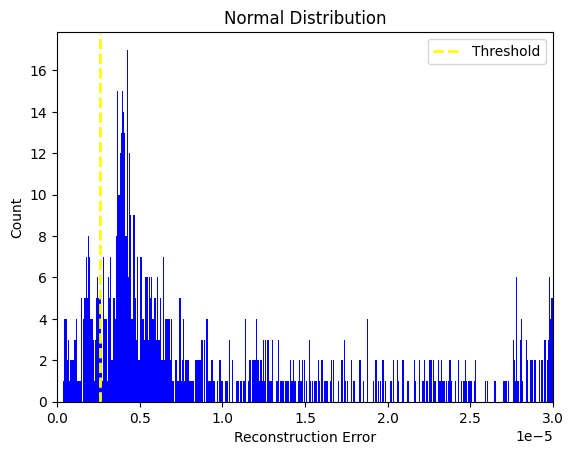

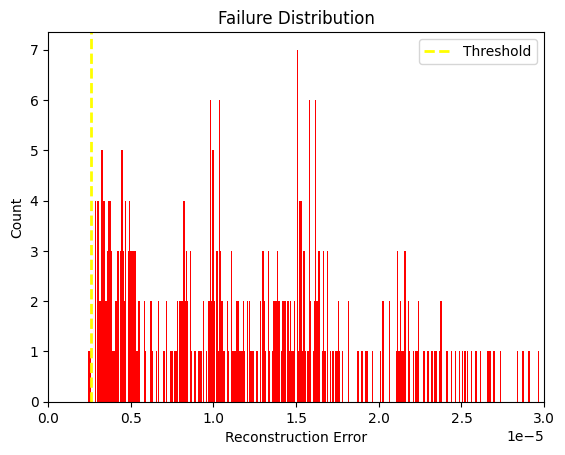

In [12]:
# test_db_type = [60, 120]

model = tf.keras.models.load_model('./Model_G/db_type_60_time_step_10_batch_128_node_256_gen/db_type_60_time_step_10_batch_128_node_256_gen.h5')

# for temp in test_db_type:
for temp in [60]:
    if temp == 60:
        db = test_db_60
    elif temp == 120:
        db = test_db_120

    # for t in timestep_list:
    for t in [10]:
        test_pred = model.predict(np.array(db[f'{t}']['x']))
        mse = np.mean(np.power(flatten(np.array(db[f'{t}']['x'])) - flatten(test_pred), 2), axis=1)
        error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': db[f'{t}']['y']})
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
        _ = ax.hist(normal_error_df.reconstruction_error.values, bins=10000, color='blue')
        _ = ax.axvline(7.68840192602238E-06, color='yellow', linestyle='--', linewidth=2, label='Threshold')
        _ = ax.set_xlim(0, 0.00003)
        _ = ax.set_xlabel('Reconstruction Error')
        _ = ax.set_ylabel('Count')
        _ = ax.set_title('Normal Distribution')
        _ = ax.legend()
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        fraud_error_df = error_df[error_df['true_class'] == 1]
        _ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10000, color='red')
        _ = ax.axvline(7.68840192602238E-06, color='yellow', linestyle='--', linewidth=2, label='Threshold')
        _ = ax.set_xlim(0, 0.00003)
        _ = ax.set_xlabel('Reconstruction Error')
        _ = ax.set_ylabel('Count')
        _ = ax.set_title('Failure Distribution')
        _ = ax.legend()

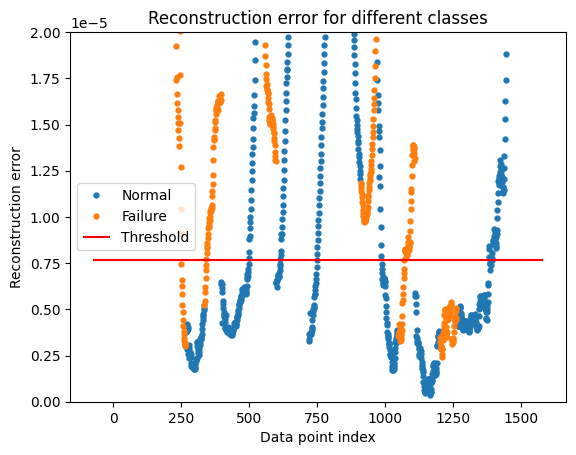

In [19]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]

groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Failure" if name == 1 else "Normal")
ax.hlines(best_thresh, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.ylim(0, 0.00002)
plt.show();

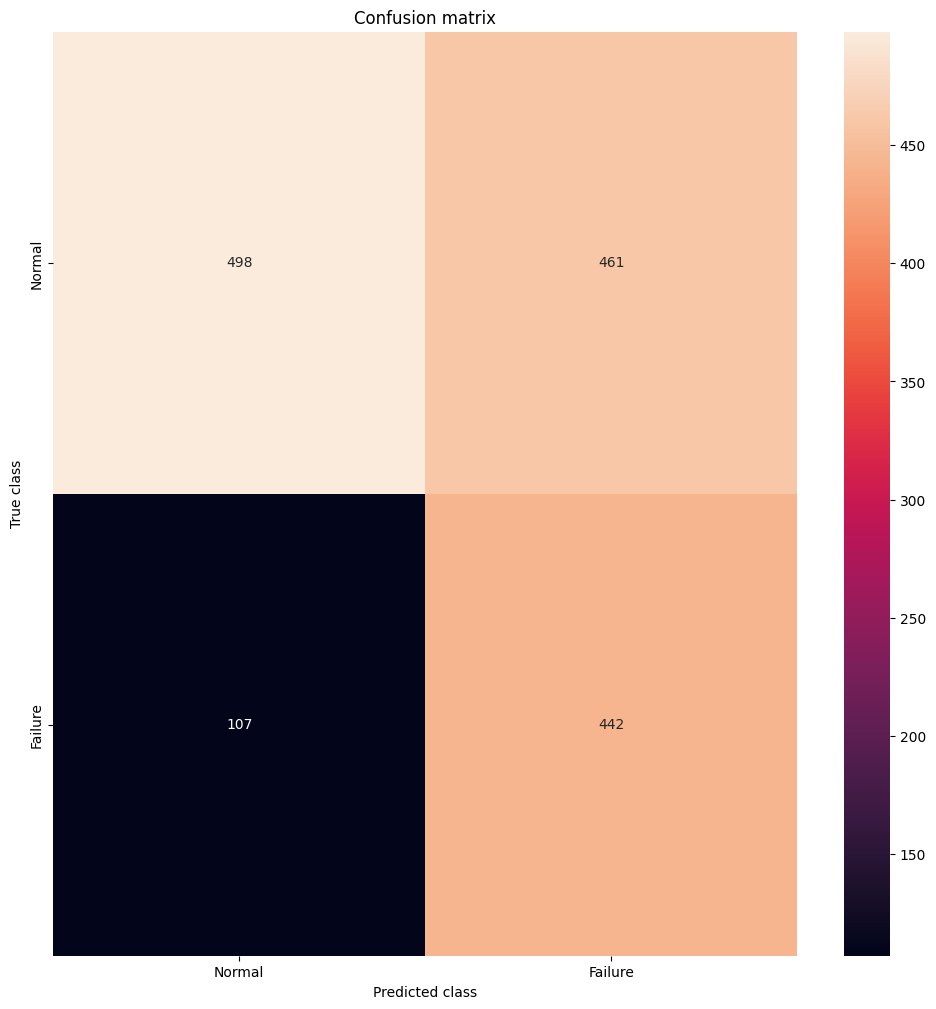

In [15]:
LABELS = ["Normal", "Failure"]
y_pred = [1 if e > best_thresh else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()